<a href="https://colab.research.google.com/github/EltonGS/BC_DS_projeto_modulo_3/blob/main/Notebooks/modelo_prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# importando as bibliotecas que serão utilizadas
import pandas as pd # biblioteca utilizada para análise dos dados

import matplotlib.pyplot as plt # visualização dos dados

from fbprophet import Prophet # biblioteca utilizada para previsão de séries temporais

In [2]:
# endereço dados que serão utilizados para o projeto
url_sa = 'https://raw.githubusercontent.com/EltonGS/BC_DS_projeto_modulo_3/main/dados_tratados/dados_sa.csv'

# lendo os dados
dados_sa = pd.read_csv(url_sa)

In [3]:
# transformando os dados da coluna data do dataframe no formato datetime
dados_sa['data'] = pd.to_datetime(dados_sa['data'], format='%Y-%m-%d')

In [4]:
# visualização dos dados
dados_sa.head(3)

,cidade,codigo_cidade,data,semana_epidem,populacao,populacao_2019,is_last,is_repeated,casos_confirmados,casos_por_100k_habitantes,data_atualizacao,taxa_mortalidade,obitos,estado,casos_novos,obitos_novos
0,Santo André,3547809.0,2020-03-16,202012,721368.0,718773.0,False,False,1,0.13863,2020-03-16,0.0,0,SP,1,0
1,Santo André,3547809.0,2020-03-17,202012,721368.0,718773.0,False,False,1,0.13863,2020-03-17,0.0,0,SP,0,0
2,Santo André,3547809.0,2020-03-18,202012,721368.0,718773.0,False,False,6,0.83175,2020-03-18,0.0,0,SP,5,0


O **Prophet** utiliza um padrão para receber os dados e conseguir identificar o que é cada informação. Assim precisamos criar um dataframe com as **colunas 'ds' (datestamp)** e **'y'**. A coluna 'ds' receberá os dados de tempo em um formato identificável pelo **Pandas**, idealmente no formato AAAA-MM-DD para data. A coluna 'y' deve conter valores numéricos e representa a medida que será prevista.

Serão criados 2 dataframes, um que receberá os dados utilizados para treinar o modelo de previsão e outro dataframe com os dados para que possamos testar o o modelo criado.

O dataframe de treino receberá os primeiros 80% dos dados e o dataframe de treino contará com os 20% restante.

In [5]:
# criação do dataframe que receberá os dados de treino
df = pd.DataFrame()
df_teste = pd.DataFrame()

In [6]:
# criação das coluna no dataframe df de treino com 85% dos dados
df['ds'] = dados_sa['data'][:400]
df['y'] = dados_sa['casos_novos'][:400]

# criação das colunas do dataframe de teste com 20% dos dados
df_teste['ds'] = dados_sa['data'][400:]
df_teste['y'] = dados_sa['casos_novos'][400:]

In [7]:
# visualização dos dados no dataframe df de treino e teste
display(df.head(3))
display(df_teste.head(3))

,ds,y
0,2020-03-16,1
1,2020-03-17,0
2,2020-03-18,5


,ds,y
400,2021-04-20,282
401,2021-04-21,427
402,2021-04-22,85


Com o dataframe de treino no padrão aceito pelo Facebook Prophet podemos criar o modelo.

In [8]:
# criando o modelo a ser utilizado para a previsão
modelo = Prophet()

Após a criação é necessário treinar o modelo com o dataframe, será informado o dataframe criado com os dados para treino.

In [9]:
# treinando o modelo com os dados do dataframe de treino
modelo.fit(df)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Podemos ver na log acima que o Facebook Prophet desabilitou a sazonalidade anual e diária para nossos dados, já identificando que existe uma sazonalidade semanal.

Após o treinamento é necessário a criação do dataframe que receberá os dados com a previsão do modelo.

In [10]:
# criação do dataframe que receberá os dados da previsão
dataframefuturo = modelo.make_future_dataframe(periods = 70)

O Prophet realiza a criação de um dataframe com o mesmo tamanho do dataframe de treino. O parâmetro periods indica o período que desejamos prever, em nosso caso o dataframe de teste possui 94 linhas e dessa maneira podemos testar a previsão realizada pelo modelo.

Com esse dataframe criado podemos realizar a previsão.

In [11]:
# realização da previsão pelo Prophet
previsao = modelo.predict(dataframefuturo)

In [12]:
# visualiando os dados da previsão
previsao.head(3)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-03-16,16.324847,-162.457327,21.974210,16.324847,16.324847,-87.174514,-87.174514,-87.174514,-87.174514,-87.174514,-87.174514,0.0,0.0,0.0,-70.849667
1,2020-03-17,17.097172,-26.375021,150.367791,17.097172,17.097172,45.693830,45.693830,45.693830,45.693830,45.693830,45.693830,0.0,0.0,0.0,62.791003
2,2020-03-18,17.869498,-50.524779,138.448890,17.869498,17.869498,25.612700,25.612700,25.612700,25.612700,25.612700,25.612700,0.0,0.0,0.0,43.482197


Acima vemos o dataframe criado pelo Prophet com a previsão. Temos a coluna ds, que foi informada no início. A coluna yhat que contém a previsão e as colunas yhat_lower e yhat_upper que definem o intervalo de confiança.

Com esse dataframe podemos plotar as informações e verificar a previsão do Prophet.

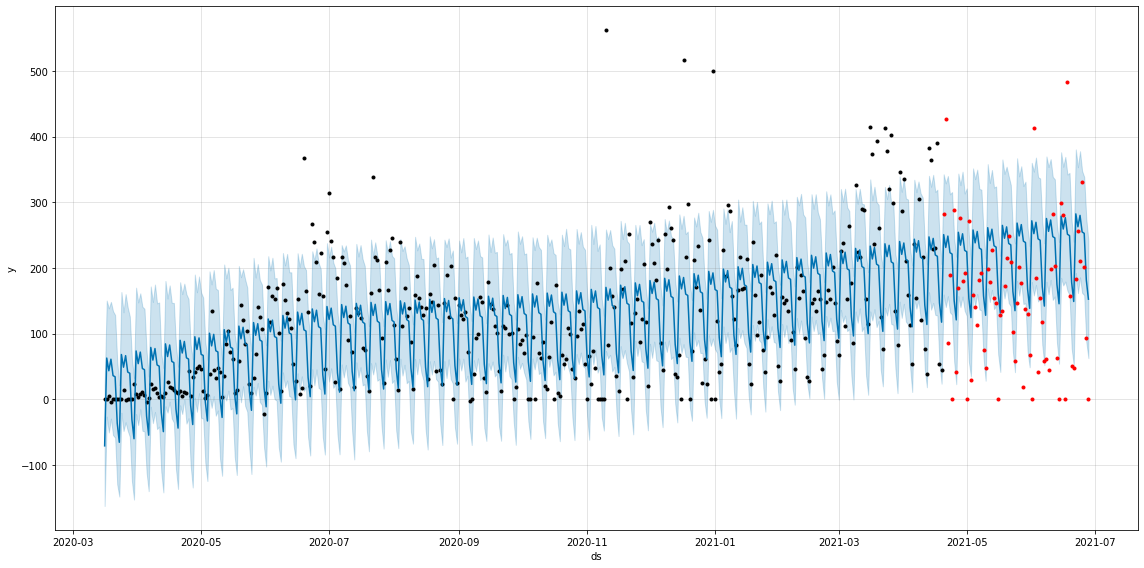

In [13]:
# plotando os dados da previsão gerada pelo Prophet
modelo.plot(previsao, figsize=(16, 8));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

Figura 1: Gráfico com a previsão gerada pelo Prophet

No gráfico acima vemos que o Prophet identificou a tendência (linha azul escuro) e o intervalor de confiança (área azul claro). Os pontos pretos são os dados do dataframe. Temos também os dados que separamos para testar o modelo (pontos vermelhos).

Vemos que a tendência identificada não sofre muitas alterações ao longo do tempo e diversos dados estão fora do intervalo de confiança. Analisando os dados de teste vemos que ainda são necessários ajustes ao modelo.

Podemos também verificar como o Prophet está decompondo nossos dados.

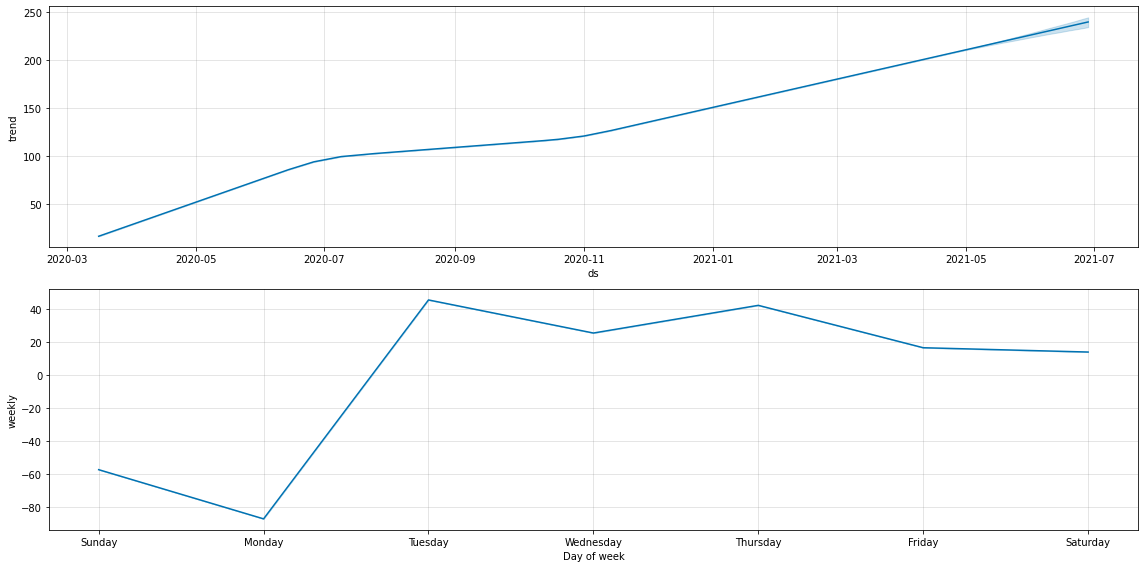

In [14]:
# plotando a decomposição que o Prophet fez com os dados
modelo.plot_components(previsao, figsize=(16, 8));

**Figura 2**: Gráfico de decomposição dos dados gerado pelo Prophet

No gráfico acima vemos a tendência e a sazonalidade semanal que o Prophet identificou.

Lembrando que essa previsão foi realizada sem passarmos nenhum parâmetro para o Prophet.
Alguns dos parâmetros que podemos informar ao Prophet são os feriados ao longo do período, a sensibilidade a changepoints dos dados, o número máximo de changepoints identificados e indicar se a sazonalidade é aditiva ou multiplicativa.

Vamos começar alterando o tipo de sazonalidade que o Prophet aplica aos dados.

O Prophet aplica, por padrão, uma sazonalidade aditiva quando analisa os dados e cria a previsão.

- Sazonalidade aditiva: Quando o padrão da sazonalidade é constante. Para encontrar os valores da próxima sazonalidade devemos somente adicionar o padrão ao longo da tendência.

- Sazonalidade multiplicativa: Quando o padrão da sazonalidade não é constante, ele se multiplica ao longo da tendência.

In [15]:
# modelo com a sazonalidade multiplicativa
modelo = Prophet(seasonality_mode='multiplicative')

In [16]:
# treinando o modelo
modelo.fit(df)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [17]:
# criando o dataframe para receber a previsão
dataframefuturo = modelo.make_future_dataframe(periods=94)

In [18]:
# gerando a previsão
previsao = modelo.predict(dataframefuturo)

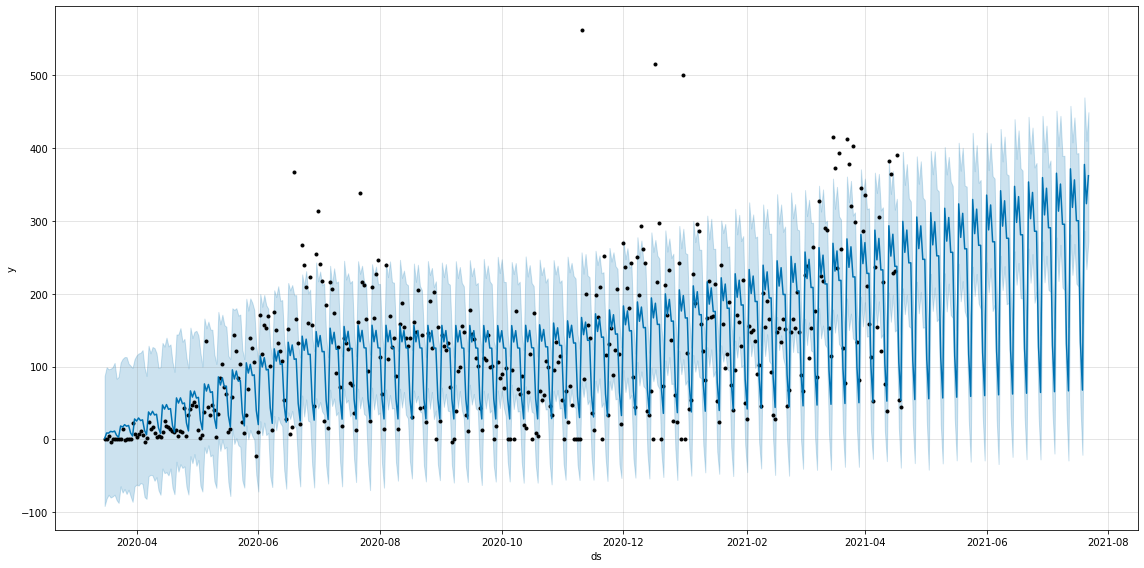

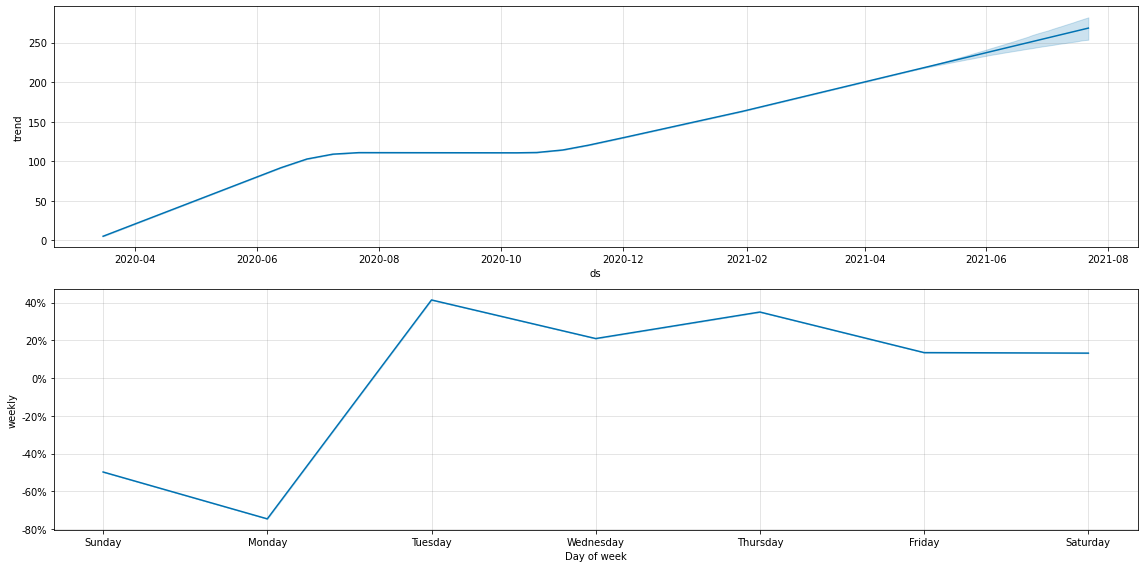

In [19]:
# plotando o gráfico com a previsão
modelo.plot(previsao, figsize = (16, 8));

# plotando a decomposição dos dados
modelo.plot_components(previsao, figsize=(16, 8));

Graficos com a sazonalidade multiplicativa.

Podemos ver que a sazonalidade multiplicativa se adequa melhor aos nosso casos tendo os dados reais mais cobertos pela tendência e intervalo de confiança, mas ainda assim o Prophet parece não identificar muito bem onde nossos dados tem uma mudança de tendência tanto para queda no número de casos, quanto para o aumento.

Vamos agora analisar os changepoints identificados pelo Prophet em nossos dados e como podemos alterar esse parâmetro.

In [20]:
# importando o módulo para verificarmos os changepoints
from fbprophet.plot import add_changepoints_to_plot

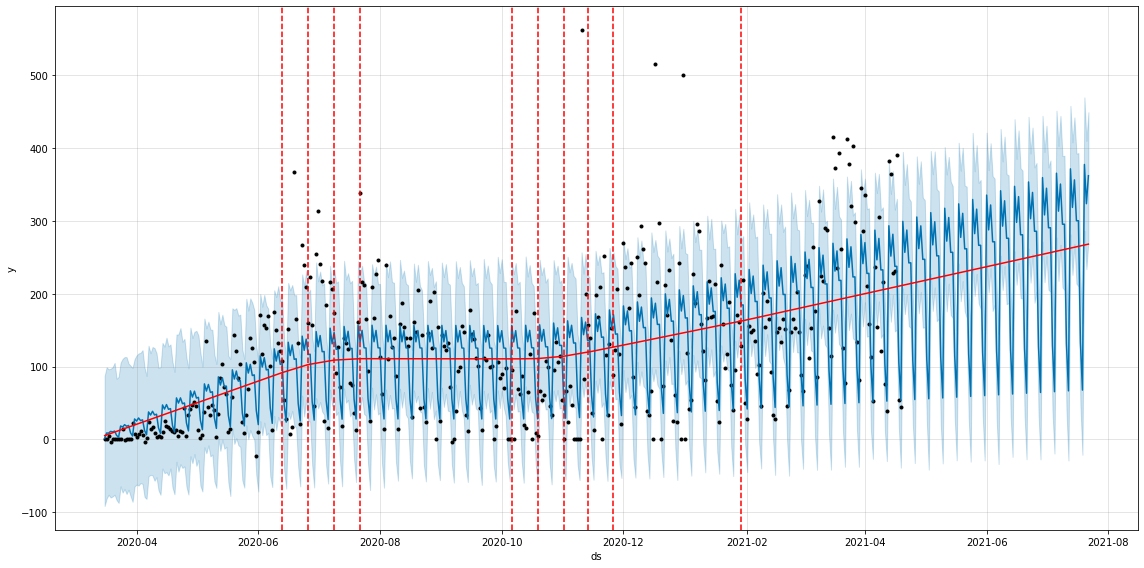

In [21]:
# plotando o gráfico novamente o salvando em uma variável para adicionarmos os changepoints
fig = modelo.plot(previsao, figsize=(16, 8))

# adicionando os changepoints ao gráfico
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

Figura 3: Gráfico com os changepoints identificados pelo Prophet

No gráfico acima vemos que o Prophet identificou 10 changepoints em nossos dados, alterando nesses pontos a tendência da previsão.

Alterando a sensibilidade do Prophet para identificar os changepoints será que teriamos uma tendência diferente? Por padrão o valor desse parâmetro é 0.05, vamos alterá-lo para 1.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


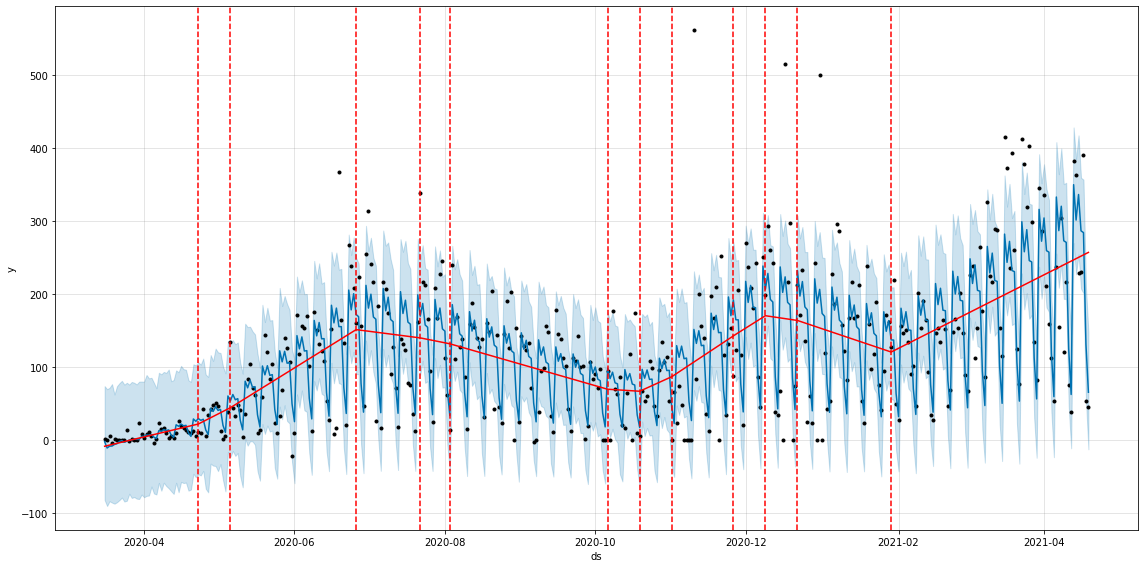

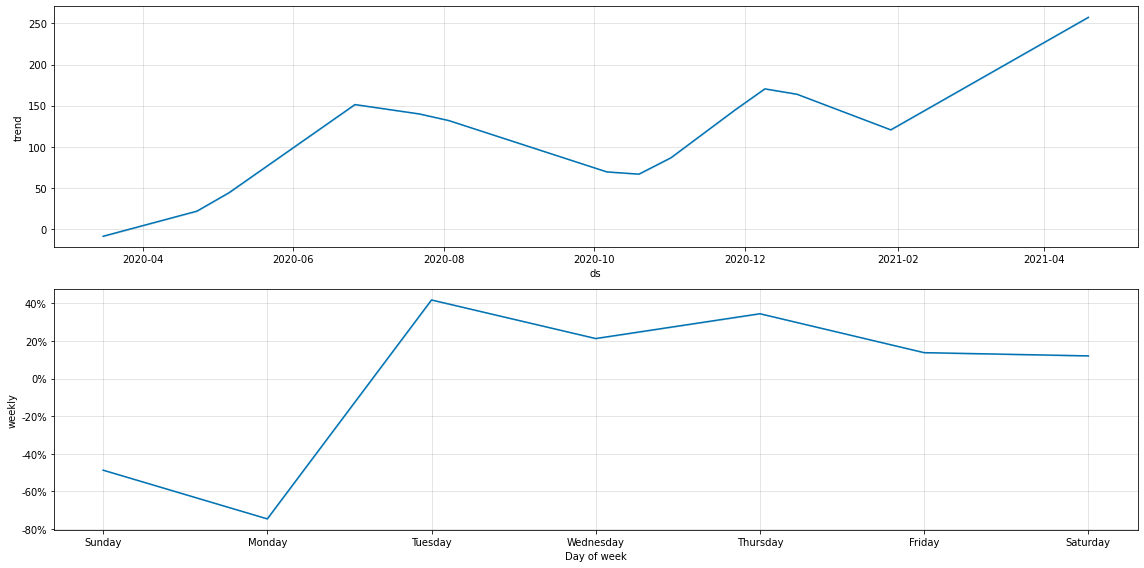

In [22]:
# criando o modelo com o parâmetro de sensibilidade com os changepoints
modelo2 = Prophet(changepoint_prior_scale=1, seasonality_mode='multiplicative')

# treinando o modelo
modelo2.fit(df)

# criando o dataframe para receber a previsao
dataframefuturo2 = modelo2.make_future_dataframe(periods = 0)

# realizando a previsão
previsao2 = modelo2.predict(dataframefuturo2)

# plotando o novo modelo e adicionando os changepoints na visualização
fig2 = modelo2.plot(previsao2, figsize=(16, 8));
a = add_changepoints_to_plot(fig2.gca(), modelo2, previsao2)

# plotando a decomposição dos componenetes analisados pelo Prophet
modelo2.plot_components(previsao2, figsize=(16, 8));

Figura 4: Gráfico da previsão com o parâmetro de sensibilidade aos changepoints alterado para 1.

No gráfico acima vemos que a alteração feita ao parâmetro para identificação dos changepoints alterou significativamente a tendência identificada pelo Prophet.

Será esse o melhor valor para nosso dados? Vejamos.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


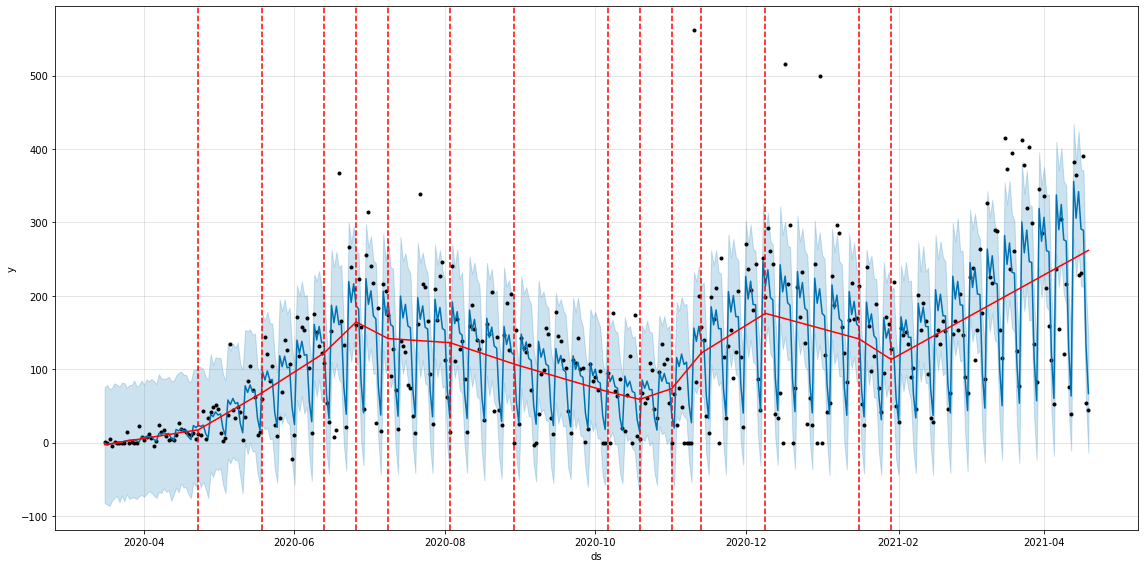

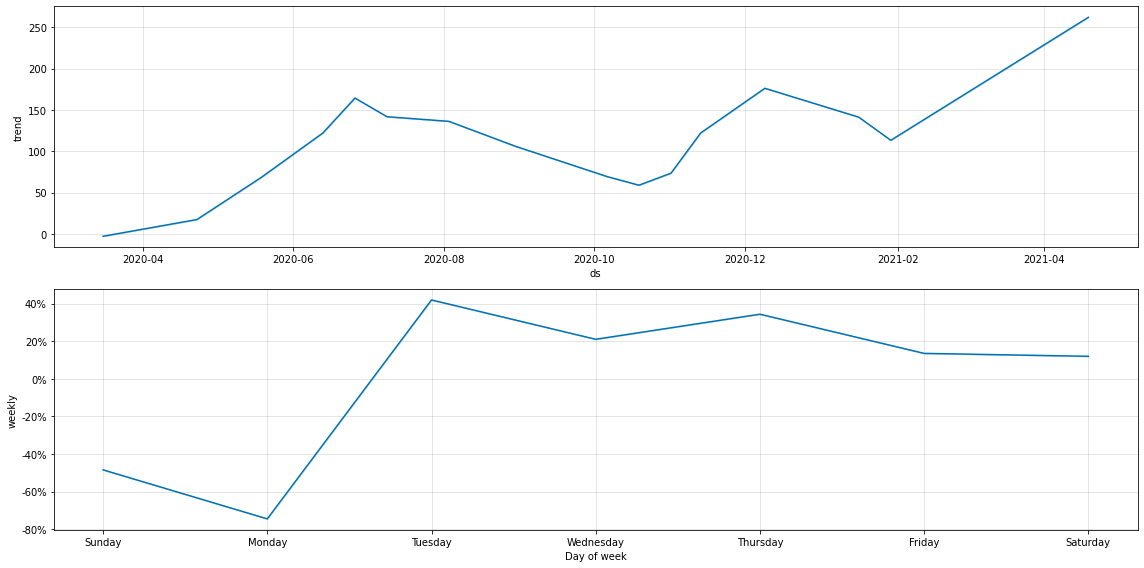

In [23]:
# criando o modelo alterando o parâmetro de sensibilidade com os changepoints
modelo3 = Prophet(changepoint_prior_scale = 4, seasonality_mode='multiplicative')

# treinando o modelo
modelo3.fit(df)

# criando o dataframe para receber a previsao
dataframefuturo3 = modelo3.make_future_dataframe(periods = 0)

# realizando a previsão
previsao3 = modelo3.predict(dataframefuturo3)

# plotando o novo modelo e adicionando os changepoints na visualização
fig3 = modelo3.plot(previsao3, figsize=(16, 8));
a = add_changepoints_to_plot(fig3.gca(), modelo3, previsao3)

# plotando a decomposição dos componenetes analisados pelo Prophet
modelo3.plot_components(previsao3, figsize=(16, 8));

Figura 5: Gráfico da previsão com o parâmetro de sensibilidade aos changepoints alterado para 4.

Vemos que aumentando o valor da sensibilidade a changepoints o Prophet identificou ainda mais pontos onde a tendência muda. Quando iniciamos eram 10 pontos, agora temos 15.

Vamos aumentar o valor da sensibilidade mais uma vez?

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


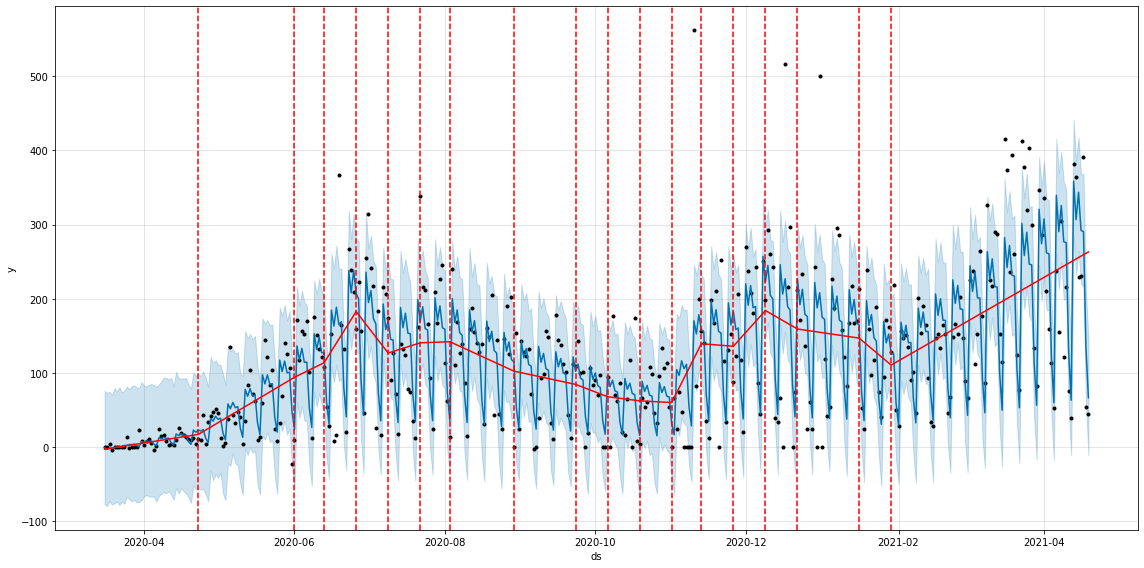

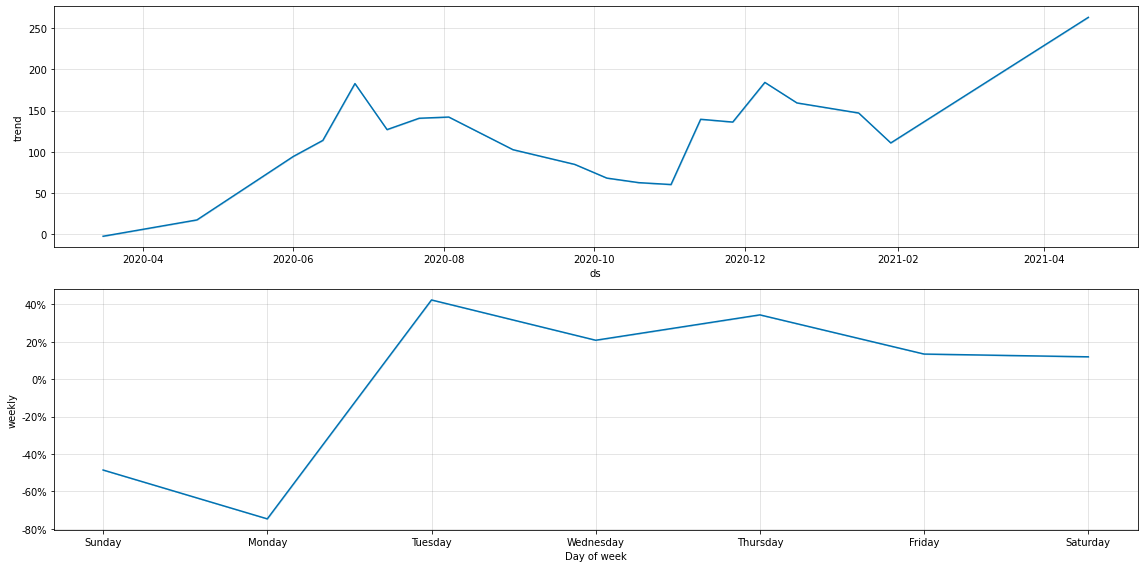

In [24]:
# criando o modelo alterando o parâmetro de sensibilidade com os changepoints
modelo4 = Prophet(changepoint_prior_scale = 8, seasonality_mode='multiplicative')

# treinando o modelo
modelo4.fit(df)

# criando o dataframe para receber a previsao
dataframefuturo4 = modelo4.make_future_dataframe(periods = 0)

# realizando a previsão
previsao4 = modelo4.predict(dataframefuturo4)

# plotando o novo modelo e adicionando os changepoints na visualização
fig4 = modelo4.plot(previsao4, figsize=(16, 8));
a = add_changepoints_to_plot(fig4.gca(), modelo4, previsao4)

# plotando a decomposição dos componenetes analisados pelo Prophet
modelo4.plot_components(previsao4, figsize=(16, 8));

Figura 6: Gráfico da previsão com o parâmetro de sensibilidade aos changepoints alterado para 8.

No gráfico acima dobramos o valor da sensibilidade quando comparado ao gráfico anterior e tivemos uma mudança significativa em como o Prophet identifica os changepoints assim temos mudanças mais agudas de tendência.

E se tentarmos um valor intermediário entre o 4, usado anteriormente, e o 8 que utilizamos agora?

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


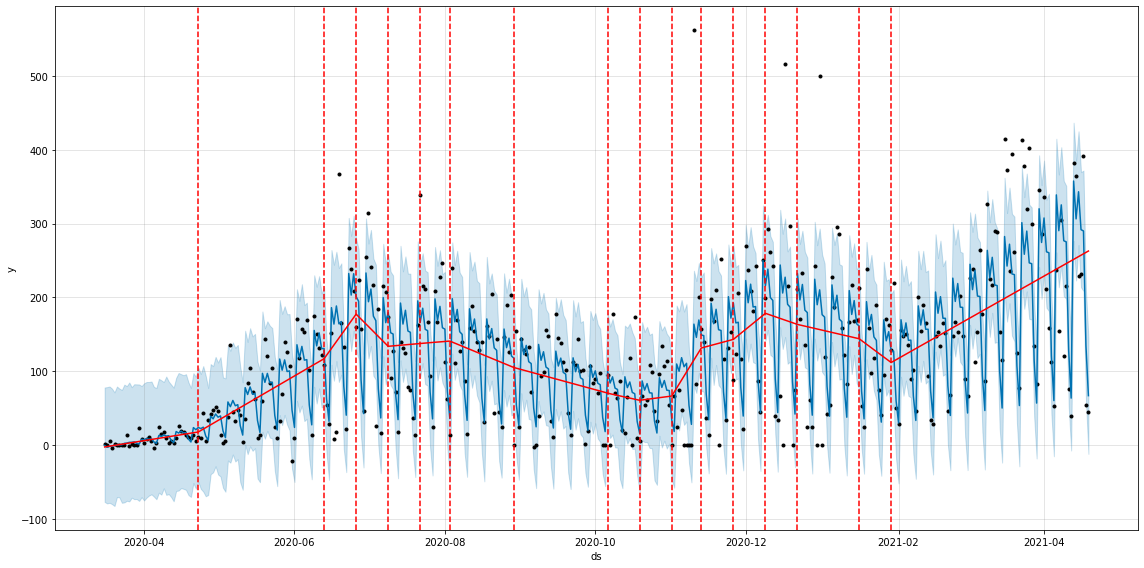

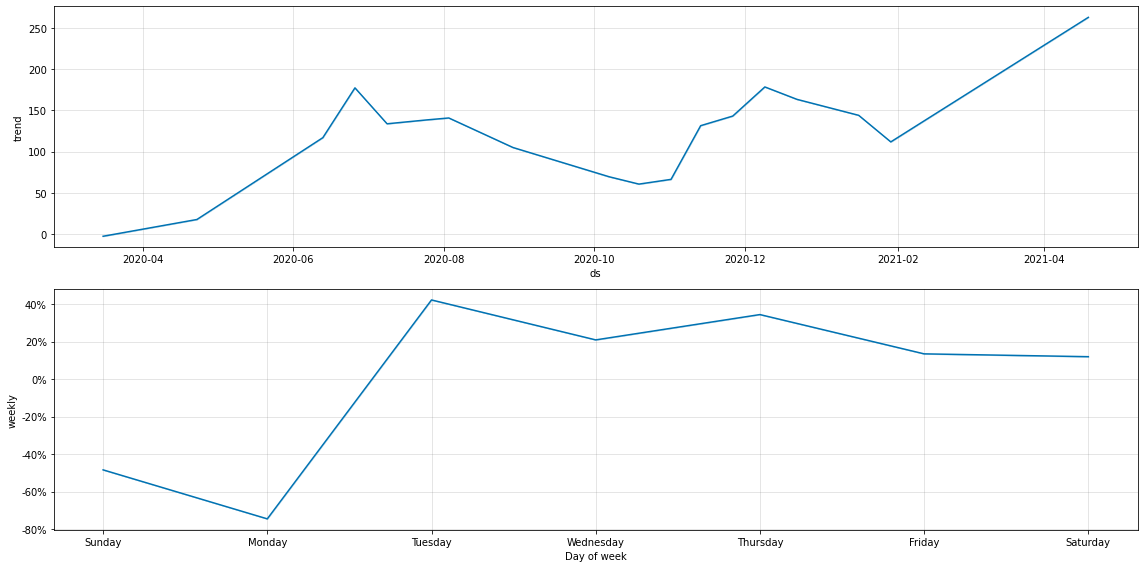

In [25]:
# criando o modelo alterando o parâmetro de sensibilidade com os changepoints
modelo5 = Prophet(changepoint_prior_scale = 6, seasonality_mode='multiplicative')

# treinando o modelo
modelo5.fit(df)

# criando o dataframe para receber a previsao
dataframefuturo5 = modelo5.make_future_dataframe(periods = 0)

# realizando a previsão
previsao5 = modelo5.predict(dataframefuturo4)

# plotando o novo modelo e adicionando os changepoints na visualização
fig5 = modelo5.plot(previsao5, figsize=(16, 8));
a = add_changepoints_to_plot(fig5.gca(), modelo5, previsao5)

# plotando a decomposição dos componenetes analisados pelo Prophet
modelo5.plot_components(previsao5, figsize=(16, 8));

Figura 7: Gráfico da previsão com o parâmetro de sensibilidade aos changepoints alterado para 6.

Como podemos ver no gráfico no gráfico acima, configurando o valor da sensibilidade aos changepoints em 6 gerou uma tendência mais próxima a que tinhamos com o valor definido em 4 mas ainda sim muito sensível a qualquer alteração nos dados. Acredito que definindo a sensibilidade em 1 seja o melhor valor para nosso modelo pois assim o Prophet está acompanhando a tendência dos dados mas não está identificando qualquer pequena alteração de tendência no dados.

O Prophet por padrão utiliza 80% dos dados informados para determinar os changepoints. Nos nosso dados temos um pico de novos casos de Covid-19 que aconteceu entre março e abril de 2021. Para que esse período seja verificado pelo Prophet vamos alterar esse parâmetro.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


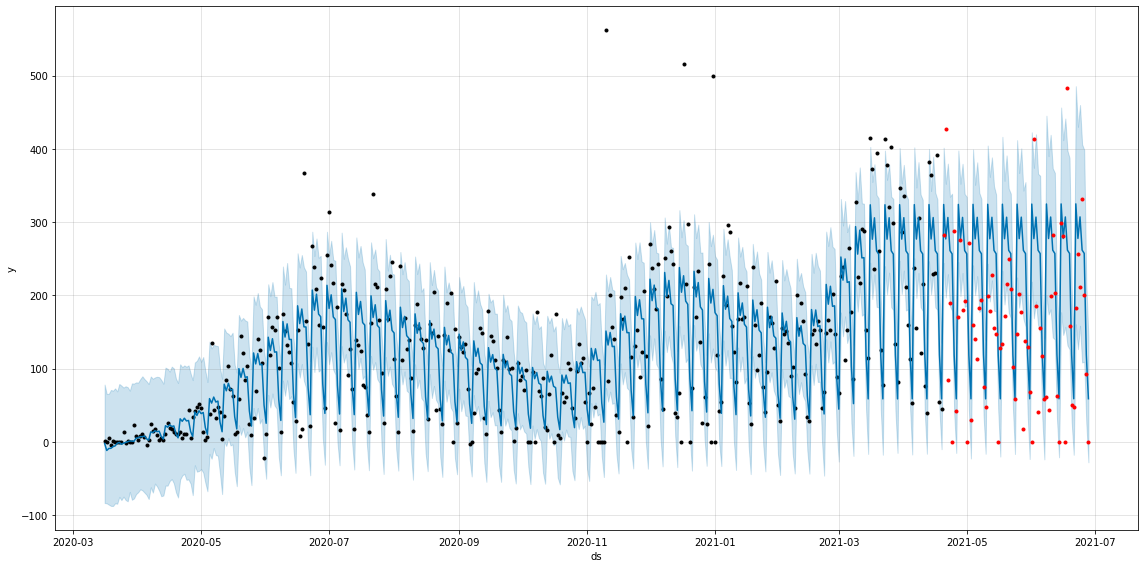

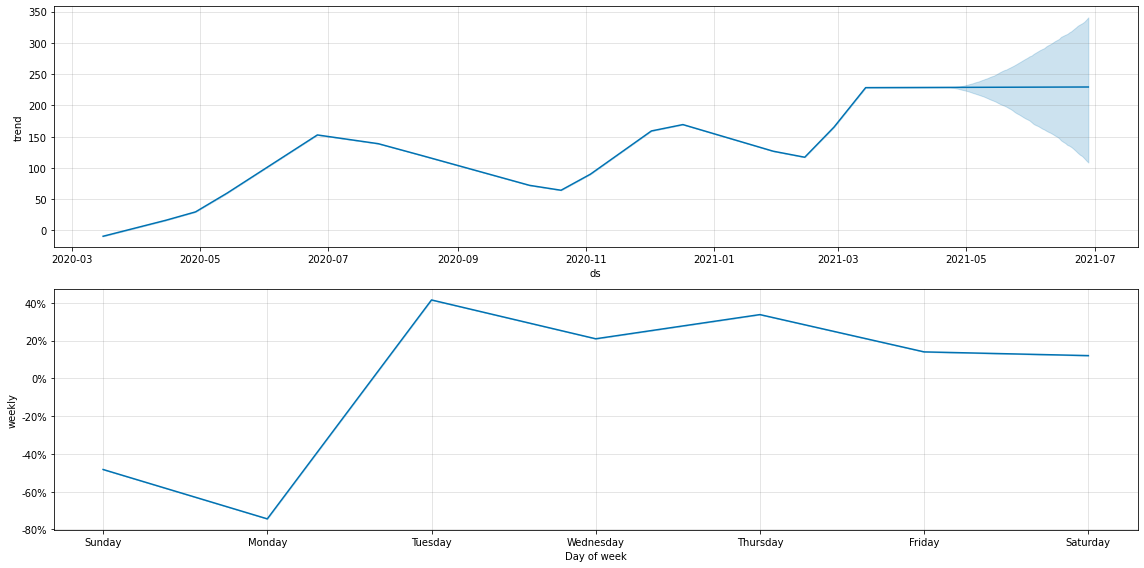

In [26]:
# criação do modelo
modelo = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=1, changepoint_range=0.91)

# treino do modelo
modelo.fit(df)

# criação do dataframe que receberá a previsão
dataframefuturo = modelo.make_future_dataframe(periods = 70)

# efetuando a previsão
previsao = modelo.predict(dataframefuturo)

# plotando o novo modelo e os dados de teste
modelo.plot(previsao, figsize=(16, 8));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

# plotando a decomposição dos componenetes analisados pelo Prophet
modelo.plot_components(previsao, figsize=(16, 8));

Gráfico alterando os dados que o Prophet utiliza para definir os changepoints.

Podemos ver que alterando o valor para 91% serem analisados para gerar os changepoints gera uma tendência melhor para os dados de teste.

Outro parâmetro que podemos indicar ao Prophet são as datas dos feriados no período dos nossos dados. Assim o Prophet pode analisar como isso impactou os dados e contabilizar isso na criação do modelo.

In [27]:
# criando listas com os feriados em Santo André para 2020 e 2021
feriados_2020 = [
               '2020-04-08',
               '2020-04-10',
               '2020-04-21',
               '2020-05-01',
               '2020-05-25',
               '2020-06-11',
               '2020-09-07',
               '2020-10-12',
               '2020-11-02',
               '2020-11-15',
               '2020-11-20',
               '2020-12-25'
]

feriados_2021 = [
                 '2021-01-01',
                 '2021-03-29',
                 '2021-03-30',
                 '2021-03-31',
                 '2021-04-01',
                 '2021-04-02',
                 '2021-05-01'
]

Para informar os feriados ao Prophet os dados precisam estar em um dataframe com duas colunas chamadas holiday e ds. Na coluna ds estarão as datas dos feriados, cada linha se refere a um feriado.

In [28]:
# criando dataframes com as listas dos feriados
feriados_sa_2020 = pd.DataFrame({'holiday': 'sa_2020',
                                 'ds' : pd.to_datetime(feriados_2020)})

feriados_sa_2021 = pd.DataFrame({'holiday': 'sa_2021',
                                 'ds' : pd.to_datetime(feriados_2021)})

# juntando os dataframe acima em um que será informado ao Prophet
feriados = pd.concat((feriados_sa_2020, feriados_sa_2021))

# visualizado o dataframe criado
display(feriados.head(3))
display(feriados.tail(3))

,holiday,ds
0,sa_2020,2020-04-08
1,sa_2020,2020-04-10
2,sa_2020,2020-04-21


,holiday,ds
4,sa_2021,2021-04-01
5,sa_2021,2021-04-02
6,sa_2021,2021-05-01


Com o dataframe dos feriados criado, podemos indicar para o Prophet essas datas junto com os parâmentros que foram definidos anteriormente e verificar como isso altera a tendência do modelo.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


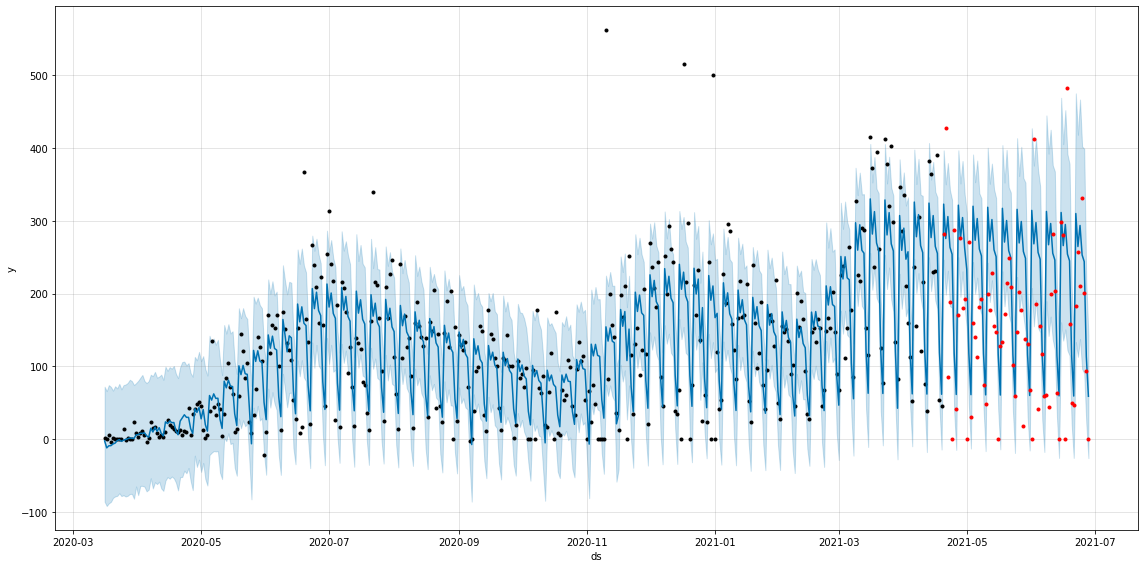

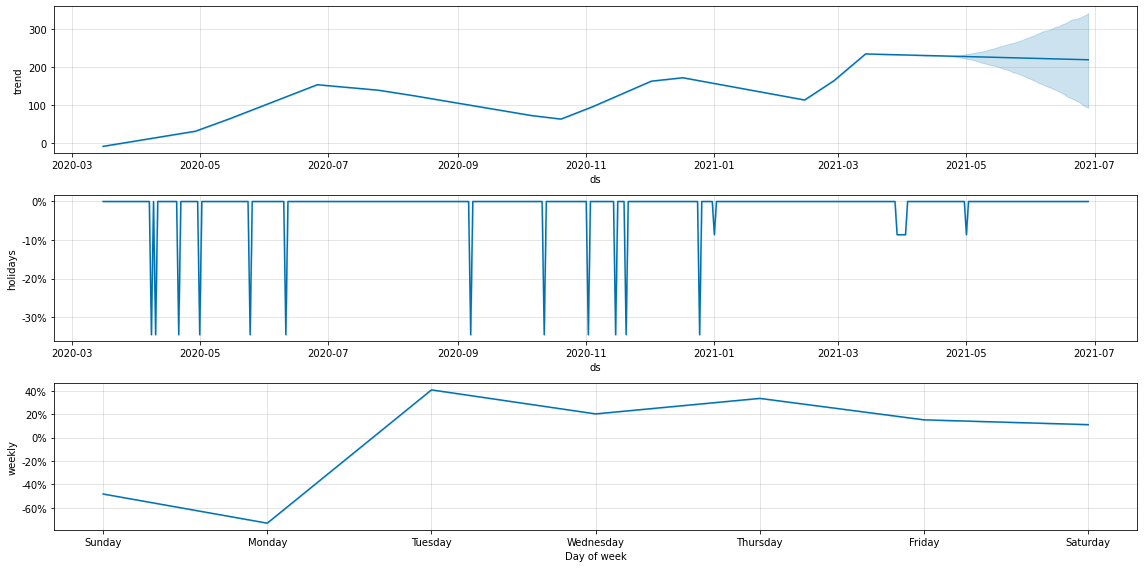

In [29]:
# criação do modelo
modelo = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=1, changepoint_range=0.91, holidays=feriados)

# treino do modelo
modelo.fit(df)

# criação do dataframe que receberá a previsão
dataframefuturo = modelo.make_future_dataframe(periods = 70)

# efetuando a previsão
previsao = modelo.predict(dataframefuturo)

# plotando o novo modelo e os dados de teste
modelo.plot(previsao, figsize=(16, 8));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

# plotando a decomposição dos componenetes analisados pelo Prophet
modelo.plot_components(previsao, figsize=(16, 8));

Gráfico com os feriados informados ao Prophet.

No gráfico acima vemos como a tendência se adaptou aos feriados informados e também no gráfico de decomposição agora vemos como os feriados afetam a tendência.

É possível perceber também que alguns pontos estão fora da tendência e também do intervalo de confiança por serem valor muito altos ou baixos. Esses são chamados de outliers.

Outliers são dados que se distanciam radicalmente de todos os outros.

Remover esses dados pode gerar uma tendência mais ajustada aos nossos dados. Para identificar esses pontos podemos utilizar o intervalo de confiança gerado no pelo Prophet no dataframe de previsão. Lembrando que o intervalo de confiança é criado pelas colunas ***yhat_upper*** e ***yhat_lower***.

In [30]:
# criando novo dataframe para verificarmos os valores fora do intervalo de confiança
novo_df = df

In [31]:
# visualizando o novo dataframe
novo_df.head(3)

,ds,y
0,2020-03-16,1
1,2020-03-17,0
2,2020-03-18,5


In [32]:
# criando um dataframe para receber os dados sem os outliers
sem_outliers = novo_df[(novo_df['y'] > previsao['yhat_lower'][:400]) & (novo_df['y'] < previsao['yhat_upper'][:400])]

# visualizando os dados sem outliers
sem_outliers.head()

,ds,y
0,2020-03-16,1
1,2020-03-17,0
2,2020-03-18,5
3,2020-03-19,-4
4,2020-03-20,1


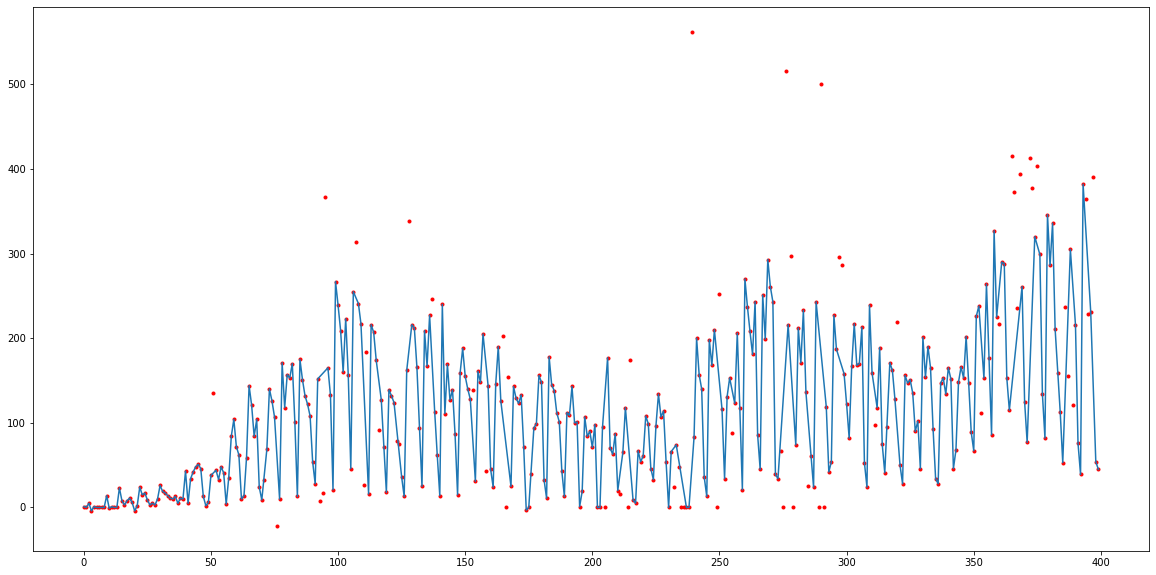

In [33]:
# visualização dos dados que foram excluídos como outliers
# criação da figura e eixos
fig, ax = plt.subplots(figsize = (20 , 10))

plt.plot(df.index, df['y'], '.r')
plt.plot(sem_outliers.index, sem_outliers['y'])

Gráfico com os dados que foram identificados como outliers.

Os pontos vermelhos que a linha azul não conecta são os dados que foram identificados como outliers por estarem fora do intervalo de confiança e da tendência.

Com esses pontos identificados podemos realizar nossa previsão novamente.

In [34]:
# criação do novo dataframe a ser informado ao Prophet
df_sem_outliers = sem_outliers[['ds', 'y']]

# visualização do novo dataframe
df_sem_outliers.head(3)

,ds,y
0,2020-03-16,1
1,2020-03-17,0
2,2020-03-18,5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


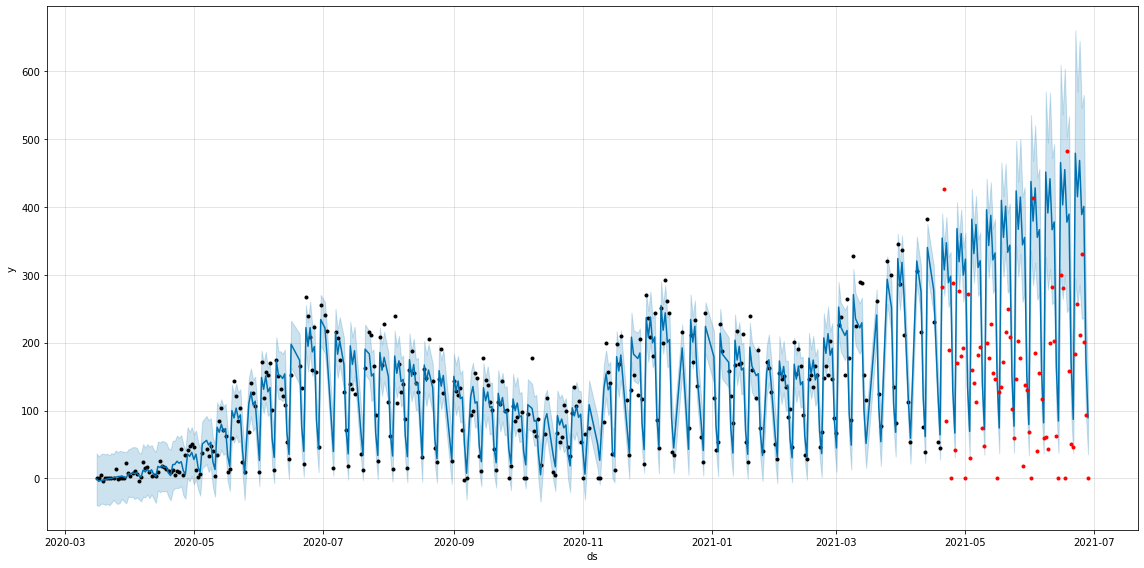

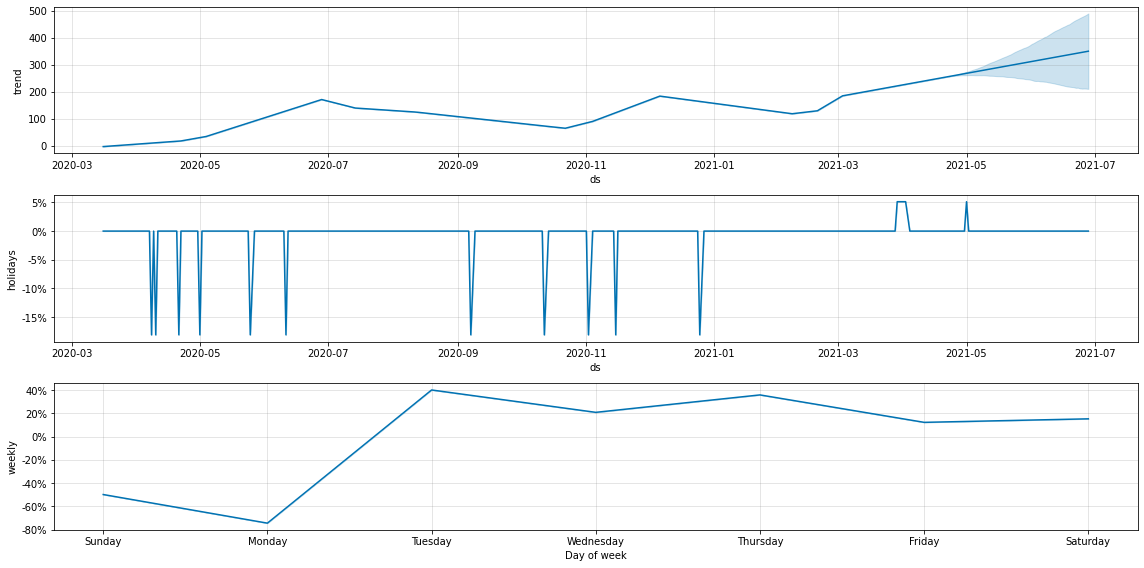

In [35]:
# criação do modelo
modelo = Prophet(seasonality_mode='multiplicative', changepoint_prior_scale=1, changepoint_range=0.91, holidays=feriados)

# treino do modelo
modelo.fit(df_sem_outliers)

# criação do dataframe que receberá a previsão
dataframefuturo = modelo.make_future_dataframe(periods = 70)

# efetuando a previsão
previsao = modelo.predict(dataframefuturo)

# plotando o novo modelo e os dados de teste
modelo.plot(previsao, figsize=(16, 8));
plt.plot(df_teste['ds'], df_teste['y'], '.r')

# plotando a decomposição dos componenetes analisados pelo Prophet
modelo.plot_components(previsao, figsize=(16, 8));

Gráfico com a nova tendência e previsão gerado após a remoção dos outliers.

Como podemos ver agora temos novos pontos que estão fora da tendência e do intervalo de confiança pois o Prophet se ajustou aos novos dados que informamos.

Agora com nosso modelo podemos medir quanto ele está acertando suas previsões através da validação cruzada que o Prophet oferece.

Para realizar a validação cruzada do modelo o Prophet necessita de alguns parâmetros:
- o modelo criado;
- **initial**: valor que indica o período que o Prophet utilizará inicialmente para identificar a tendência do modelo. No total nós temos 470 dias e serão passados 210 (7 meses) como período inicial.
- **horizon**: valor que indica o período que o Prophet preverá a cada validação que realizar. Aqui serão 30 dias.
- **period**: valor que indica o período que o Prophet realizará novas previsões. Aqui queremos novas previsões a cada 30 dias.

In [36]:
# importando a validação cruzada do prophet
from fbprophet.diagnostics import cross_validation

In [37]:
# criando o dataframe que receberá a validação cruzada
df_cv = cross_validation(modelo, initial= '210 days', horizon = '30 days', period = '30 days')

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-10-21 00:00:00 and 2021-03-20 00:00:00


In [38]:
# visualização do dataframe com a validação cruzada
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2020-10-22,77.706055,45.090878,107.480075,61,2020-10-21
1,2020-10-23,66.026896,37.608566,96.795821,108,2020-10-21
2,2020-10-24,59.837663,28.637380,89.556284,99,2020-10-21
3,2020-10-25,28.682003,-1.916152,57.784876,46,2020-10-21
4,2020-10-26,8.750465,-20.064546,39.208436,33,2020-10-21


No datafarme acima temos as previsões e intervalo de confiança gerados pela validação cruzada.

Os cutoffs são as datas até onde os dados foram usados para testar o modelo. Abaixo visualizaremos essas datas.

In [39]:
# visualizando os períodos onde foram feitas as validações
cutoff = df_cv['cutoff'].unique()
cutoff

array(['2020-10-21T00:00:00.000000000', '2020-11-20T00:00:00.000000000',
       '2020-12-20T00:00:00.000000000', '2021-01-19T00:00:00.000000000',
       '2021-02-18T00:00:00.000000000', '2021-03-20T00:00:00.000000000'],
      dtype='datetime64[ns]')

Temos 6 períodos utilizados como cutoff pelo Prophet com base nos parâmetros que informamos. O primeiro teste utilizado os dados até 21-10-2020 para gerar a tendência e previsão e compara com os dados dos próximo 30 dias, como definimos no horizon. Depois ele utiliza os dados até o dia 20-11-2020 e compara com os próximos 30 dias, e assim até chegar ao fim do nosso modelo.

Para verificarmos se o nosso modelo está bem ajustado podemos utilizar as métricas de performance do Prophet a partir dos dados da validação cruzada.

In [40]:
# importando as métricas de performance do Prophet
from fbprophet.diagnostics import performance_metrics

In [41]:
# criando um dataframe que receberá as métricas de performance
df_p = performance_metrics(df_cv)

INFO:fbprophet:Skipping MAPE because y close to 0


In [42]:
# visualização das métricas de performance
df_p

,horizon,mse,rmse,mae,mdape,coverage
0,3 days,2176.260100,46.650403,36.961842,0.326899,0.457143
1,4 days,2907.739334,53.923458,44.990309,0.388971,0.400000
2,5 days,2851.256594,53.397159,42.213028,0.365383,0.514286
3,6 days,2415.315455,49.145859,38.922118,0.267274,0.571429
4,7 days,2234.059384,47.265837,37.149912,0.252256,0.571429
5,8 days,1834.837165,42.834999,35.300840,0.267274,0.500000
6,9 days,2128.129484,46.131654,38.030186,0.270694,0.414286
7,10 days,1773.326189,42.110880,34.228243,0.279709,0.464286
8,11 days,1852.361544,43.039070,36.806397,0.279709,0.404762
9,12 days,2315.265949,48.117211,41.333586,0.279651,0.428571


No dataframe acima temos as métricas calculadas pelo Prophet para o modelo criado. Ele calcula as métricas para cada 30 dias, período que definimos como o parâmetro horizon.

Podemos visualizar essas métricas em um gráfico.

In [43]:
# importando o módulo para plotar um gráfico com as informações das métricas de performance do modelo
from fbprophet.plot import plot_cross_validation_metric

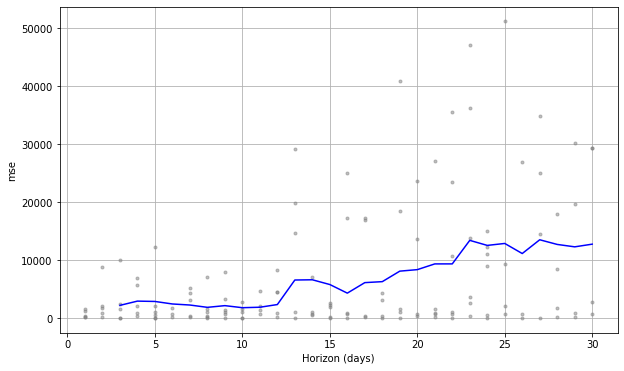

In [44]:
# visualização da métrica mean squared error
plot_cross_validation_metric(df_cv, metric='mse');

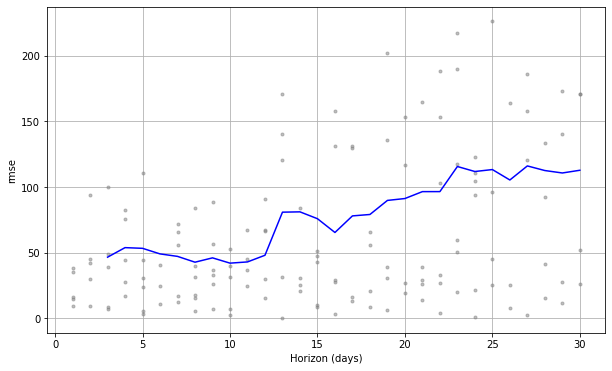

In [45]:
# visualização da métrica root mean squared error / raiz quadrada do erro médio ao quadrado
plot_cross_validation_metric(df_cv, metric='rmse');

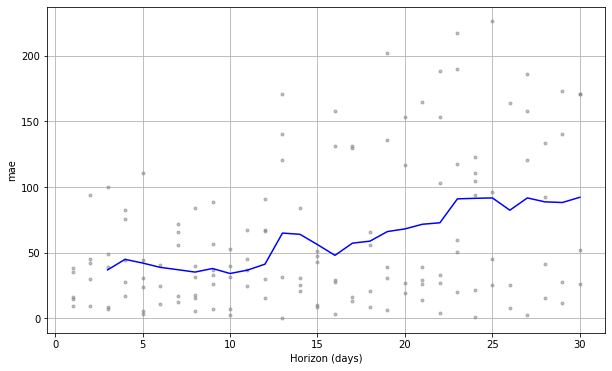

In [46]:
# visualização da métrica mean absolute error / erro médio absoluto
plot_cross_validation_metric(df_cv, metric='mae');

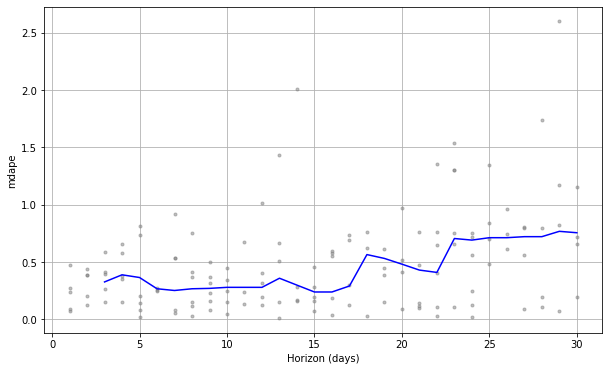

In [47]:
# visualização da métrica median absolute percent error / erro percentual absoluto mediano
plot_cross_validation_metric(df_cv, metric='mdape');

Vemos nos gráficos com as métricas de performance que conforme os dias passam na previsão o erro vai aumentando em nosso modelo. Até próximo de 15 dias os erros estão baixo mas aumentam gradativamente.

O modelo ainda pode ser melhorado, talvez ainda sejam necessário alguns ajustes nos parâmetros que utilizamos para diminuir os erros e assim melhorar sua performance.

O projeto atual será concluído aqui. Sinta-se a vontade para trabalhar com o modelo e alterar seus parâmetros para melhorar a performance medida.